## Testing performance of BOW,TF-IDF on Amazon Fine food Dataset from kaggle

## Dataset
This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. 
## Task
 
#### Input - ProductId, UserId, ProfileName, HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text 
#### Ouput- To determine whether BOW or TF-IDF performs a better vectorization.

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer

In [5]:
con=sqlite3.connect('database.sqlite')

In [6]:
filtered_data=pd.read_sql_query("""select * from Reviews where score!=3 """,con)

#### We classify the score(4-5) as positive and score(1-2) as negative and discard score=3

In [7]:
filtered_data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
525809,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
525810,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
525811,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
525812,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [8]:
def partition(x):
    if x<3:
        return 'negative'
    else:
        return 'positive'

In [9]:
real_score=filtered_data['Score']
positivenegative=real_score.map(partition)
filtered_data['Score']=positivenegative

In [10]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Data Cleaning

In [11]:
sorted_df=filtered_data.sort_values('ProductId',axis=0,ascending=True)

In [12]:
sorted_df.shape

(525814, 10)

#### Removing duplicates for same user with text for different products on same time

In [13]:
sorted_df=sorted_df.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)

In [14]:
sorted_df.shape

(364173, 10)

#### Data remaining after removing duplicates = 69% (intial = 525814, now=364173)

In [15]:
final=sorted_df[sorted_df.HelpfulnessNumerator <= sorted_df.HelpfulnessDenominator]

In [16]:
final.shape

(364171, 10)

#### Helpfulness numerator is total positive reviews and helpfullness denominator is total of both +ve,-ve. so, removing redudunant rows

In [18]:
final['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

### Text to vector mapping
### 1. Bag of Words

In [19]:
count_vec=CountVectorizer()
# It will convert all text to lower case by default
final_counts=count_vec.fit_transform(final['Text'].values)

In [20]:
#### final_counts is a sparse matrix represenattion
final_counts.get_shape()

(364171, 115281)

### Text-preprocessing - Stopwords,lemmatization,stemming

1. Removing HTML tags
2. Removing punctuations
3. Check for english letter and word is not alpha-numeric
4. len(words)>2
5. converting words to lowercase 
6. stemming

In [21]:
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

stop=set(stopwords.words('english'))
snow=nltk.stem.SnowballStemmer('english')

In [22]:
def clean_html(sent):
    clean=re.compile('<.*?>')
    cleantext=re.sub(clean,' ',sent)
    return cleantext

In [23]:
def cleanpunc(sent):
    cleaned=re.sub(r'[?|!|\'|"|#]',r'',sent)
    cleaned=re.sub(r'[.|,|)|(|/]',r' ',cleaned)
    return cleaned
             

In [25]:
i=0
final_string=[]
pos_words=[]
neg_words=[]
for sent in final['Text'].values:
    fil_sen=[]
    sent=clean_html(sent)
    for w in sent.split():
        for clean_words in cleanpunc(w).split():
            if((clean_words.isalpha())&(len(clean_words)>2)):
                if(clean_words.lower() not in stop):
                    s=(snow.stem(clean_words.lower())).encode('utf8')
                    fil_sen.append(s)
                    if((final['Score'].values)[i]=='positive'):
                        pos_words.append(s)
                    else:
                        neg_words.append(s)
                else:
                    continue
            else:
                continue
        
    strl=b" ".join(fil_sen)
    final_string.append(strl)
    i+=1

In [26]:
final['cleaned_text']=final_string

C:\Users\vingo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
final[['Text','cleaned_text']].head()

### Bi-Grams and N-grams

In [27]:
# calculating freq of +ve and -ve words
freq_dist_pos=nltk.FreqDist(pos_words)
freq_dist_neg=nltk.FreqDist(neg_words)


In [28]:
print('Most common +ve words',freq_dist_pos.most_common(20))
print('Most common -ve words',freq_dist_neg.most_common(20))

Most common +ve words [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
Most common -ve words [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]


#### Considering bigram,trigram,ngram because of overlap of words frokm positive and negative freq dist eg. like occured both in +ve and -ve reviews

In [29]:
count_vec=CountVectorizer(ngram_range=(1,2))
final_counts=count_vec.fit_transform(final['Text'].values)

In [30]:
final_counts.get_shape()

(364171, 2910192)

#### After calculating bigrams dimensions increased from (364171, 115281) to (364171, 2910192)

### TF-IDF

In [31]:
tf_vec=TfidfVectorizer(ngram_range=(1,2))
final_tf_idf=tf_vec.fit_transform(final['Text'].values)

In [32]:
final_tf_idf.get_shape()

(364171, 2910192)

In [33]:
features=tf_vec.get_feature_names()

In [34]:
features[10000:10009]

['14 count',
 '14 country',
 '14 crackers',
 '14 credit',
 '14 crude',
 '14 cup',
 '14 cupcakes',
 '14 cups',
 '14 currants']

In [35]:
def top_tfidf_features(rows,features,top_n=25):
    top_ids=np.argsort(rows)[::-1][:top_n]
    top_feat=[(features[i],rows[i]) for i in top_ids]
    df=pd.DataFrame(top_feat)
    df.columns=['features','tfidf']
    return df
top_idf=top_tfidf_features(final_tf_idf[1,:].toarray()[0],features,25)

In [36]:
top_idf

,features,tfidf
0,sendak books,0.173437
1,rosie movie,0.173437
2,paperbacks seem,0.173437
3,cover version,0.173437
4,these sendak,0.173437
5,the paperbacks,0.173437
6,pages open,0.173437
7,really rosie,0.168074
8,incorporates them,0.168074
9,paperbacks,0.168074


### Word2Vector

In [37]:
import gensim
i=0
list_sent=[]
for sent in final['Text'].values:
    fil_sen=[]
    sent=clean_html(sent)
    for w in sent.split():
        for clean_words in cleanpunc(w).split():
            if((clean_words.isalpha())):
                fil_sen.append(clean_words)
            else:
                continue
    list_sent.append(fil_sen)
                

In [38]:
print(final['Text'].values[0])
print("******************************************************")
print(list_sent[0])

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
******************************************************
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'hes', 'learned', 'about', 'whales', 'India', 'drooping', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'STILL', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is', 'in', 'co

In [39]:
# min_count indicates words with min 5 occurances and construct a vector
# size - dimensions of vectors to be constructed.(more corpus, size should be high)
# workers - for using cores in cpu
w2v_model=gensim.models.Word2Vec(list_sent,min_count=5,size=50,workers=4)

In [40]:
words=list(w2v_model.wv.vocab)
print(len(words))

44605


In [41]:
w2v_model.wv.most_similar('tasty')

[('yummy', 0.882380485534668),
 ('tastey', 0.8757591843605042),
 ('satisfying', 0.8572615385055542),
 ('delicious', 0.8438938856124878),
 ('filling', 0.8437792062759399),
 ('flavorful', 0.8245435953140259),
 ('delicous', 0.7948806285858154),
 ('addicting', 0.7854294776916504),
 ('versatile', 0.780021071434021),
 ('delish', 0.774552583694458)]

### KNN Classification on Time-stamp based Split

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection  import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_auc_score

In [49]:
def part(x):
    if x=="positive":
        return 1
    else:
        return 0

In [50]:
X=final_tf_idf
y_map=final['Score'].map(part)

In [52]:
final['score_n']=y_map

C:\Users\vingo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [62]:
y=np.array(final['score_n'])

In [76]:
df_samp_pos=final[final['score_n']==1].sample(n=6000)

In [77]:
df_samp_neg=final[final['score_n']==0].sample(n=6000)

In [78]:
df_samp=pd.concat([X_samp_pos,X_samp_neg])

In [79]:
# Sorting data based on time
df_samp['Time'] = pd.to_datetime(df_samp['Time'], unit = 's')
df_samp = df_samp.sort_values(by = 'Time')

In [80]:
df_samp.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,score_n
346037,374339,B00004CI84,AZRJH4JFB59VC,Lynwood E. Hines,21,23,negative,2001-08-08,"Great movie, terrible DVD",I am continually amazed at the shoddy treatmen...,b'continu amaz shoddi treatment movi get dvd r...,0
443663,479724,B00005U2FA,A1B226ZPOE0KSZ,Jack Richman,41,43,positive,2002-09-17,A good product made better,I've been using Vacu Vin's previous model for ...,b'ive use vacu vin previous model year happi o...,1
298759,323603,B0000CNU5A,A2WNWOJDL0A81,Jonathan Sprenke,1,2,positive,2003-10-06,mmmmmm salty,This product reminds me of a thousand lunches ...,b'product remind thousand lunch chicken teriya...,1
264269,286453,B0000DJ7WI,A375QRG43POEW6,dndnd,23,25,negative,2003-11-28,Stay Away...,This product ships in great packaging and it l...,b'product ship great packag look good tast hor...,0
524758,567319,B0000DNS4J,A25PNMNXMUO95V,winglesslight,2,4,negative,2004-06-21,The WORST. I THROW AWAY the whole bag.,This is the worst dried mango product. I taste...,b'worst dri mango product tast threw away whol...,0


In [81]:
df_samp.shape

(12000, 12)

As dealing with timestamp, we take first 8400 timestamps as train and remaining as test data instead of random split because reviews change according to time and random split performance is less than training into certain intervals of time and predicting next 

In [83]:
datasplit_train=df_samp.iloc[:8400,:]
datasplit_test=df_samp.iloc[8400:,:]

In [84]:
datasplit_train.shape

(8400, 12)

In [85]:
datasplit_test.shape

(3600, 12)

## 1. Applying BOW vectorization on text column

In [129]:
count_vec=CountVectorizer()
# It will convert all text to lower case by default
final_counts=count_vec.fit_transform(datasplit_train['Text'].values)

In [130]:
X=final_counts

In [131]:
Y=np.array(datasplit_train['score_n'])

### Don't perform fit_transform for text data as count_vect is already trained use transform and use count_vect from train set

In [132]:

# It will convert all text to lower case by default
final_counts=count_vec.transform(datasplit_test['Text'].values)

In [133]:
X_test=final_counts

In [134]:
Y_test=np.array(datasplit_test['score_n'])

In [97]:
# further dividing data into training and cross-validation sets
X_tr, X_cv, y_tr, y_cv = train_test_split(X, Y, test_size=0.3)

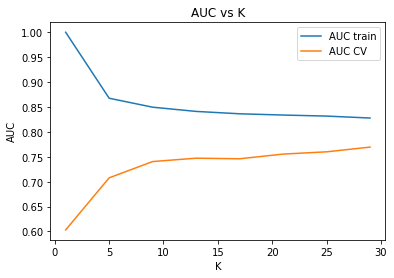

In [99]:
auc_cv=[]
auc_train=[]
K=list(range(1,30,4))
cv_scores=[]
for i in K:
    knn=KNeighborsClassifier(n_neighbors=i,weights='uniform',algorithm='brute',leaf_size=30, p=2, metric='cosine')
    knn.fit(X_tr, y_tr)
    pred = knn.predict_proba(X_cv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred))
    pred1=knn.predict_proba(X_tr)[:,1]
    auc_train.append(roc_auc_score(y_tr,pred1))      
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(K, auc_train, label='AUC train')
ax.plot(K, auc_cv, label='AUC CV')
plt.title('AUC vs K')
plt.xlabel('K')
plt.ylabel('AUC')
ax.legend()
plt.show()

In [104]:
auc_cv=[]
auc_train=[]
K=list(range(1,50,4))
cv_scores=[]
for i in K:
    knn=KNeighborsClassifier(n_neighbors=i)
    scores=cross_val_score(knn,X_tr,y_tr,cv=10,scoring='accuracy')
    cv_scores.append(scores.mean())

MSE=[1-x for x in cv_scores]
optimal_k=K[MSE.index(min(MSE))]

In [105]:
optimal_k

9

### Observation:
1. Optimal value in simple check k=29
2. Optimal K after 10fold cv check k=9
we consider k=9 as the best hyperparameter 

In [139]:
knn_opt=KNeighborsClassifier(n_neighbors=9)
knn_opt.fit(X,Y)
pred=knn_opt.predict(X_test)
acc=accuracy_score(Y_test,pred)*100


In [140]:
acc

63.11111111111111

### Total accuracy = 63.11

## 2. Applying TFIDF vectorization with knn

In [141]:
tf_vec=TfidfVectorizer(ngram_range=(1,2))
final_tf_idf=tf_vec.fit_transform(datasplit_train['Text'].values)

In [149]:
X=final_tf_idf

In [150]:
Y=np.array(datasplit_train['score_n'])

In [151]:
final_counts=tf_vec.transform(datasplit_test['Text'].values)

In [152]:
X_test=final_counts

In [153]:
Y_test=np.array(datasplit_test['score_n'])

In [154]:
X_tr, X_cv, y_tr, y_cv = train_test_split(X, Y, test_size=0.3)

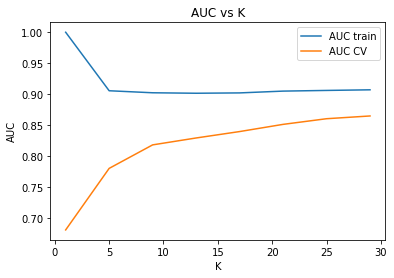

In [155]:
auc_cv=[]
auc_train=[]
K=list(range(1,30,4))
cv_scores=[]
for i in K:
    knn=KNeighborsClassifier(n_neighbors=i,weights='uniform',algorithm='brute',leaf_size=30, p=2, metric='cosine')
    knn.fit(X_tr, y_tr)
    pred = knn.predict_proba(X_cv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred))
    pred1=knn.predict_proba(X_tr)[:,1]
    auc_train.append(roc_auc_score(y_tr,pred1))      
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(K, auc_train, label='AUC train')
ax.plot(K, auc_cv, label='AUC CV')
plt.title('AUC vs K')
plt.xlabel('K')
plt.ylabel('AUC')
ax.legend()
plt.show()

In [156]:
auc_cv=[]
auc_train=[]
K=list(range(1,50,4))
cv_scores=[]
for i in K:
    knn=KNeighborsClassifier(n_neighbors=i)
    scores=cross_val_score(knn,X_tr,y_tr,cv=10,scoring='accuracy')
    cv_scores.append(scores.mean())

MSE=[1-x for x in cv_scores]
optimal_k=K[MSE.index(min(MSE))]

In [157]:
optimal_k

49

## Observation
1. optimal k=49

In [158]:
knn_opt=KNeighborsClassifier(n_neighbors=49)
knn_opt.fit(X,Y)
pred=knn_opt.predict(X_test)
acc=accuracy_score(Y_test,pred)*100


In [159]:
acc

79.13888888888889

### Total accuracy = 79.11

## Results
1. Knn performed better on TF-IDF vectorized Amazon fine food text compared to Bag of words vectorization 